The purpose of this notebook is to demonstrate a diagnostic test for when the overlap between population and sample eignvectors of outlying eigenvalues begins to fluctuate.

<b>Theoretical set-up and relevant results</b>. Our set-up is that we have an $N \times M$ matrix $X$.  Denote by $m(z)$ the limiting Stieltjes transform of $X^* X$ and $\tilde{m}(z)$ that of $X X^*$,
$$
m(z) := \lim \frac{1}{M} \mathrm{tr} \frac{1}{ X^* X - z }, \qquad \tilde{m} (z) := \lim \frac{1}{N} \mathrm{tr} \frac{1}{ X X^* - z }
$$
Recall 
$$
\gamma m(z) = \frac{1-\gamma}{z} + \tilde{m}(z)
$$
where $\gamma = \frac{M}{N}$.

A result which can be proven in a few cases, which I believe to be universal as long as the spiked population eigenvectors are delocalized, is that if $\lambda_1$ is a spiked sample eigenvalue, then it is asymptotically Gaussian with variance,
$$
\mathrm{Var}(\lambda_1 ) \approx \frac{2}{N \tilde{m}' ( \lambda_1) }
$$

Something we know from the various works of Knowles-Yin and Bloemendal-Knowles-Yau-Yin is that the overlap between the sample and population eigenvectors concentrates on a positive deterministic quantity unless either the distance between $\lambda_1$ and $\lambda_2$ is comparable to the scale of fluctuations of $\lambda_1$.  That is, if
$$
\lambda_1 - \lambda_2 \approx \sqrt{ \frac{2}{N \tilde{m}' ( \lambda_1 ) } }
$$

When this occurs, we think that two things can happen.  If $\lambda_1$ and $\lambda_2$ are just two spikes that are very close together but far from the spectral bulk, then we know that the sample eigenvector $v_1$ forms some angle with the two-dimensional plane formed by the corresponding two population eigenvectors.  

If $\lambda_1$ is getting close to the spectral bulk, then we just get decorrelation with any population eigenvectors whatsoever.

<b>Proposed test</b>. The test I want to think about is that, given some eigenvalues $\lambda_i$, estimate the quantity $(N \tilde{m}' ( \lambda_1 ) )^{-1/2}$ and then calculate the quotient,
$$
D ( \lambda_1 ) = \frac{ \lambda_2 - \lambda_1}{ (N \tilde{m}' ( \lambda_1 ) )^{1/2} }.
$$
If this is too small, say $D ( \lambda_1 ) < 3$, then we suspect that we should not trust any estimate of the overlap coming from random matrix theory.

The next question is how to estimate $\tilde{m}' ( \lambda_1)$, or equivalently the limiting DOS $\rho (x)$ or $\tilde{\rho} (x)$.  For this, note that 
$$
m' (E) = \int \frac{ \rho (x)}{ (x-E)^2} d x.
$$
If $E$ is near the upper spectral edge, then the test function $x \to (x-E)^{-2}$ is relatively insensitive to the part of the measure $\rho(x)$ that is far from the spectral edge.  This suggests a simple estimator.  Given a cut-off $n$,
$$
\rho (x) \approx \frac{1}{Z} (\lambda_2-x)^{\beta} 1_{ \{ 0 < \lambda_2 -x < \lambda_n \} } + \sum_{i > n} \delta_{ \lambda_i } (x).
$$
where $\beta$ is fit from the eigenvalues $\{ \lambda_i\}_{i=2}^n$.  That is, we use the largest few eigenvalues to fit a smooth power law (I implemented this by linear regression of the log-counts on $\log(\lambda_2 - x)$), and then use delta functions for the eigenvalues further from the spectral edge.  Currently $Z$ is chosen to enforce that this is a probability measure, but if one doesn't care to ensure that $\rho(x)$ integrates to $1$ then some modification could be made.

<b>Simulations.</b> In the following simulations we will take $N=1250$ and $M=500$.  We will take $X_{ij} = Z_{ij} \sqrt{d_j}$ where $d_j$ are chosen as follows.  First, we allow $100$ of them to be $1$, to give a normal "Marcenko-Pastur" type component, and then let the other $400$ be drawn from the following distribution,
$$
d F (x) = \frac{1}{Z} (9-x)^9 1_{\{ 1 < x < 9 \} } d x
$$
(the $9$ is basically arbitrary). Note that rank $d_j$ in decreasing order.

In [1]:
#Simulate this matrix ensemble, 200 times.
import main
import imp
import numpy as np
imp.reload(main)
N=1250
M=500
n=200
eigenvalues = np.zeros((n, M))
eigenvectors = np.zeros((n, M, M))
for i in range(n):
    U, S, V, = main.randWish(N, M, main.makevar())
    eigenvalues[i, :] = S
    eigenvectors[i, :, :] = V

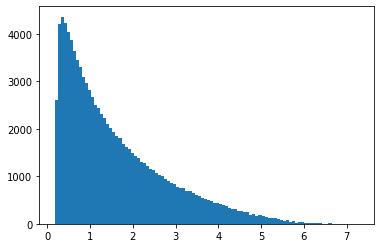

In [2]:
#plot all of the eigenvalues
import matplotlib.pyplot as plt
plt.hist(eigenvalues.flatten(), bins=100)
plt.show()

Note that the above histogram is over all $200$ trials, and an individual trial will look different; my computer is not that fast so I cannot simulate larger matrices.  Below is an example individual matrix.

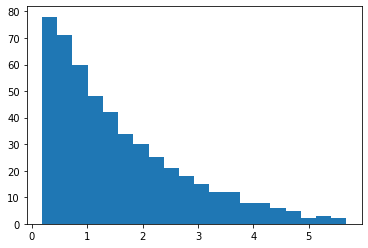

In [4]:
plt.hist(eigenvalues[0, :], bins=20)
plt.show()

In [6]:
imp.reload(main)
k=1
eigs = np.zeros((n,k+1))
vecs = np.zeros((n, k))
for i in range(n):
    eigs[i, :] = eigenvalues[i, 0:k+1]
    vecs[i, :] = np.diag(eigenvectors[i, 0:k,0:k])
dif = eigs[:, 0]-eigs[:, 1]
vecs = np.power(vecs, 2)
var = np.zeros(n)
for i in range(n):
    lambs = eigenvalues[i, :]
    var[i] = main.var_est(lambs, N, M, n=100)

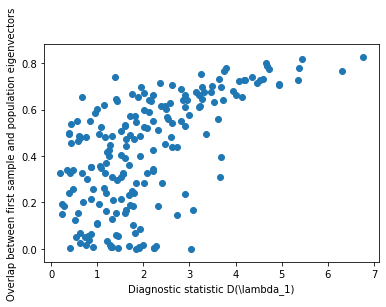

In [7]:
plt.scatter(dif.flatten()/ np.sqrt(var.flatten()), vecs.flatten())
plt.ylabel('Overlap between first sample and population eigenvectors')
plt.xlabel('Diagnostic statistic D(\lambda_1)')
plt.show()

The above plot shows the behavior of the overlap as the Diagnostic changes.  If it is larger, then the variance of the overlap is smaller

In [8]:
preds = np.zeros(n)
for i in range(n):
    preds[i] = main.m_est(np.append(eigenvalues[i, :], np.zeros(N-M)), 0)

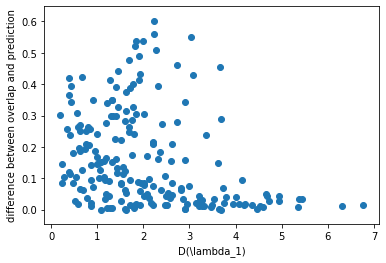

In [12]:
plt.scatter(dif.flatten()/ np.sqrt(var.flatten()), np.abs(preds.flatten()-vecs.flatten()))
plt.xlabel('D(\lambda_1)')
plt.ylabel('difference between overlap and prediction')
plt.show()

The above plot shows the difference between the true overlap and a very basic prediction I made based on the Dey-Lee formulas, as the dia